# Learning Koopman eigenfunctions on Slow manifold

The linearity, and thus the model performance, of a Koopman model can be analyzed by
comparing the linearity of the eigenfunctions evaluated on a test trajectory and the
prediction using the corresponding eigenvalue. This will be demonstrated in this
tutorial for a two-dimensional system evolving on a slow manifold.

For detailed information we refer to

[1] Kaiser, Kutz & Brunton, _"Data-driven discovery of Koopman eigenfunctions for
control"_, Machine Learning: Science and Technology, Vol. 2(3), 035023, 2021,
[2] Korda & Mezic, _"Optimal construction of Koopman eigenfunctions for prediction
and control"_, IEEE Transactions on Automatic Control, Vol. 65(12), 2020.

In [194]:
import sys
sys.path.append('../src')

In [195]:
import pykoopman as pk
import numpy as np
import numpy.random as rnd
np.random.seed(42)  # for reproducibility
import matplotlib.pyplot as plt

np.random.seed(1234)

import warnings
warnings.filterwarnings('ignore')

from pykoopman.common import slow_manifold
nonlinear_sys = slow_manifold(mu=-0.1, la=-1.0, dt=0.1)

## Collect training data

Text(0.5, 1.0, 'we can handle trajectory data with varying-length sequence!')

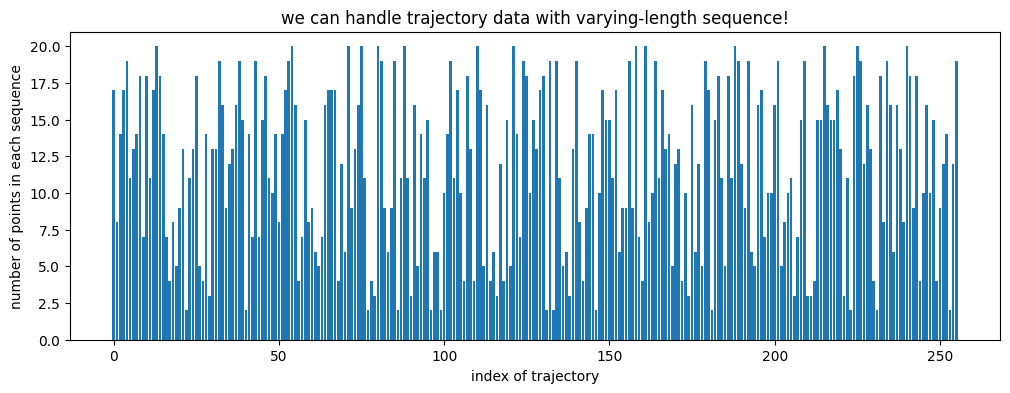

In [196]:
n_int = 1
n_pts = 16
xmin = ymin = -2
xmax = ymax = +2
xx, yy = np.meshgrid(np.linspace(xmin, xmax, n_pts), np.linspace(ymin, ymax, n_pts))
Xdat = np.vstack((xx.flatten(), yy.flatten()))

max_n_int = 20

traj_list = []
for i in range(Xdat.shape[1]):
    X, Y = nonlinear_sys.collect_data_discrete(Xdat[:,[i]],
                                               np.random.randint(1, max_n_int))
    tmp = np.hstack([X, Y[:,-1:]]).T
    traj_list.append(tmp)

plt.figure(figsize=(12,4))
plt.bar(np.arange(len(traj_list)), [len(x) for x in traj_list])
plt.xlabel('index of trajectory')
plt.ylabel('number of points in each sequence')
plt.title('we can handle trajectory data with varying-length sequence!')

test trajectory

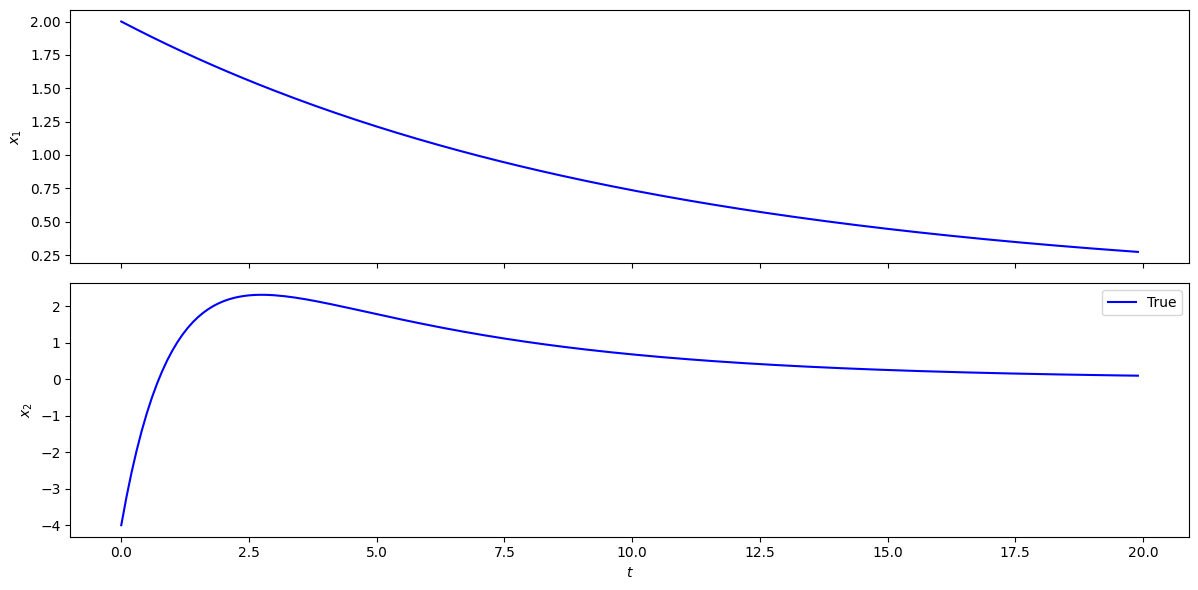

In [197]:
x0 = np.array([2, -4])  #np.array([2, -4])
T = 20
t = np.arange(0, T, nonlinear_sys.dt)
Xtest = nonlinear_sys.simulate(x0[:, np.newaxis], len(t)-1).T
Xtest = np.vstack([x0[np.newaxis, :], Xtest])
fig, axs = plt.subplots(2, 1, sharex=True, tight_layout=True, figsize=(12, 6))
axs[0].plot(t, Xtest[:, 0], '-', color='blue', label='True')
axs[0].set(ylabel=r'$x_1$')
axs[1].plot(t, Xtest[:, 1], '-', color='blue', label='True')
axs[1].set(ylabel=r'$x_2$', xlabel=r'$t$')
axs[1].legend(loc='best')

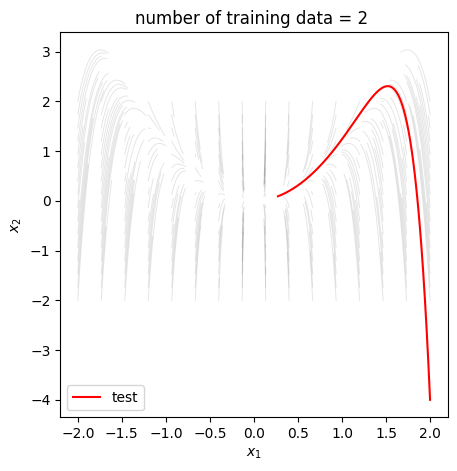

In [198]:
plt.figure(figsize=(5,5))

for X in traj_list:
    # for i in range(X.shape[-1]):
    # plt.plot([X[0,i], Y[0,i]], [X[1,i], Y[1,i]],'-k',lw=0.7,label=None)
    plt.plot(X[:,0], X[:,1],'-k', lw=0.7, label=None,alpha=0.1)

# plot test trajectory
plt.plot(Xtest[:, 0], Xtest[:, 1],'-r',label='test')
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.title(f"number of training data = {X.shape[-1]} ")
plt.legend(loc='best')

## Try EDMD with polynomial features on training data

In [199]:
X_edmd = []
Y_edmd = []
for i in range(len(traj_list)):
    X_edmd.append(traj_list[i][:-1])
    Y_edmd.append(traj_list[i][1:])

X_edmd = np.vstack(X_edmd)
Y_edmd = np.vstack(Y_edmd)

In [200]:
regr = pk.regression.EDMD()
obsv = pk.observables.Polynomial(degree=3)
model_edmd = pk.Koopman(observables=obsv, regressor=regr)
model_edmd.fit(X_edmd, y=Y_edmd, dt=nonlinear_sys.dt)

Koopman(observables=Polynomial(degree=3), regressor=EDMD())

In [201]:
koop_eigenvals = np.log(np.linalg.eig(model_edmd.A)[0])/nonlinear_sys.dt

print(f"koopman eigenvalues = {koop_eigenvals}")

koopman eigenvalues = [-1.88130165e+00+0.67548263j -1.88130165e+00-0.67548263j
 -1.65811154e+00+0.j         -3.77475828e-14+0.j
 -9.99991625e-02+0.j         -1.99998325e-01+0.j
 -2.99997487e-01+0.j         -1.09912337e+00+0.j
 -9.99124206e-01+0.j         -6.82569546e-01+0.j        ]


## Try NNDMD on training data

In [202]:
look_forward = 20
dlk_regressor = pk.regression.NNDMD(dt=nonlinear_sys.dt, look_forward=look_forward,
                                    config_encoder=dict(input_size=2,
                                                        hidden_sizes=[32] * 3,
                                                        output_size=3,
                                                        activations="swish"),
                                    config_decoder=dict(input_size=3, hidden_sizes=[],
                                                        output_size=2, activations="linear"),
                                    batch_size=1000, lbfgs=True,
                                    normalize=True, normalize_mode='equal',
                                    normalize_std_factor=1.0,
                                    trainer_kwargs=dict(max_epochs=10))

# train the vanilla NN model
model = pk.Koopman(regressor=dlk_regressor)
model.fit(traj_list, dt=nonlinear_sys.dt)

INFO: GPU available: True (cuda), used: True
[rank_zero.py:64 -                _info() ] GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
[rank_zero.py:64 -                _info() ] TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
[rank_zero.py:64 -                _info() ] IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
[rank_zero.py:64 -                _info() ] HPU available: False, using: 0 HPUs
D:\work\pykoopman\venv\lib\site-packages\lightning\pytorch\trainer\configuration_validator.py:69: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
D:\work\pykoopman\src\pykoopman\regression\_nndmd.py:898: UserWarning: Warning: no validation data prepared
  warn("Warning: no validation data prepared")
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: 

Training: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
[rank_zero.py:64 -                _info() ] `Trainer.fit` stopped: `max_epochs=10` reached.


Koopman(observables=Identity(),
        regressor=NNDMD(batch_size=1000,
                        config_decoder={'activations': 'linear',
                                        'hidden_sizes': [], 'input_size': 3,
                                        'output_size': 2},
                        config_encoder={'activations': 'swish',
                                        'hidden_sizes': [32, 32, 32],
                                        'input_size': 2, 'output_size': 3},
                        dt=0.1, lbfgs=True, look_forward=20,
                        normalize_std_factor=1.0,
                        trainer_kwargs={'max_epochs': 10}))

**Note:**
- If you didn't find the model to converge, that's because LBFGS is not very robust.
You can try again and hope it works again.

## Try NNDMD on training data but now we enforce the $A$ to be disspative

In [203]:
dlk_regressor_d = pk.regression.NNDMD(mode='Dissipative',
                                      dt=nonlinear_sys.dt,
                                      look_forward=look_forward,
                                    config_encoder=dict(input_size=2,
                                                        hidden_sizes=[32] * 3,
                                                        output_size=3,
                                                        activations="swish"),
                                    config_decoder=dict(input_size=3, hidden_sizes=[],
                                                        output_size=2, activations="linear"),
                                    batch_size=1000, lbfgs=True,
                                    normalize=True, normalize_mode='equal',
                                    normalize_std_factor=1.0,
                                    trainer_kwargs=dict(max_epochs=10))

# train the vanilla NN model
model_d = pk.Koopman(regressor=dlk_regressor_d)
model_d.fit(traj_list, dt=nonlinear_sys.dt)

INFO: GPU available: True (cuda), used: True
[rank_zero.py:64 -                _info() ] GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
[rank_zero.py:64 -                _info() ] TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
[rank_zero.py:64 -                _info() ] IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
[rank_zero.py:64 -                _info() ] HPU available: False, using: 0 HPUs
D:\work\pykoopman\venv\lib\site-packages\lightning\pytorch\trainer\configuration_validator.py:69: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
D:\work\pykoopman\src\pykoopman\regression\_nndmd.py:898: UserWarning: Warning: no validation data prepared
  warn("Warning: no validation data prepared")
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: 

Training: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
[rank_zero.py:64 -                _info() ] `Trainer.fit` stopped: `max_epochs=10` reached.


Koopman(observables=Identity(),
        regressor=NNDMD(batch_size=1000,
                        config_decoder={'activations': 'linear',
                                        'hidden_sizes': [], 'input_size': 3,
                                        'output_size': 2},
                        config_encoder={'activations': 'swish',
                                        'hidden_sizes': [32, 32, 32],
                                        'input_size': 2, 'output_size': 3},
                        dt=0.1, lbfgs=True, look_forward=20, mode='Dissipative',
                        normalize_std_factor=1.0,
                        trainer_kwargs={'max_epochs': 10}))

## Check the continuous eigenvalues

The eigenvalues identified is pretty close... to the ground truth. Although the
dissipative one is less accurate, it guarantees stability, which can be very
important for uncertainty quantification, and long time stability predictions.

In [204]:
koop_eigenvals = np.log(np.linalg.eig(model.A)[0])/nonlinear_sys.dt
print(f"koopman eigenvalues = {koop_eigenvals}")

koop_eigenvals = np.log(np.linalg.eig(model_d.A)[0])/nonlinear_sys.dt
print(f"koopman eigenvalues with dissipative enforcement = {koop_eigenvals}")

koopman eigenvalues = [-0.99603385 -0.10004931 -0.20210291]
koopman eigenvalues with dissipative enforcement = [-0.9720626  -0.09937927 -0.21690993]


## Evaluate model performance on test trajectory

In [205]:
model_d.ur

array([[ 0.4801627 , -0.06952379, -0.07016307],
       [ 0.0335696 , -2.7245688 ,  0.4008407 ]], dtype=float32)

(-4.0, 4.0)

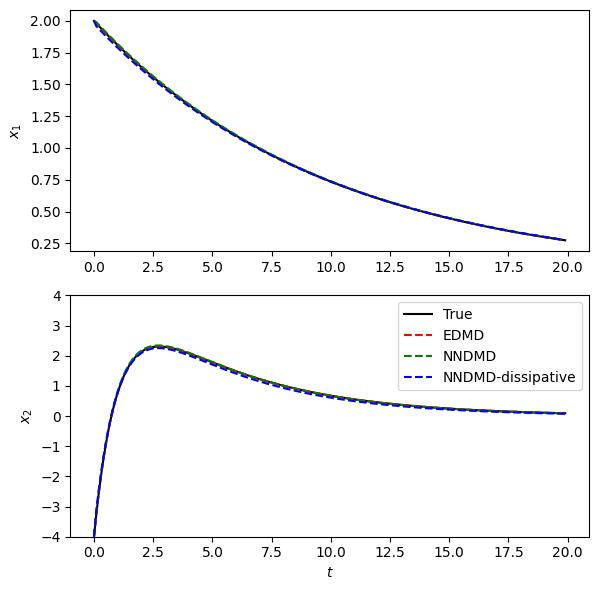

In [206]:

Xkoop_edmd = model_edmd.simulate(x0, n_steps=len(t)-1)
Xkoop_edmd = np.vstack([x0[np.newaxis,:], Xkoop_edmd])

Xkoop_nn_d = model_d.simulate(x0, n_steps=len(t)-1)
Xkoop_nn_d = np.vstack([x0[np.newaxis,:], Xkoop_nn_d])

Xkoop_nn = model.simulate(x0, n_steps=len(t)-1)
Xkoop_nn = np.vstack([x0[np.newaxis,:], Xkoop_nn])

fig, axs = plt.subplots(2, 1, tight_layout=True, figsize=(6, 6))
axs[0].plot(t, Xtest[:, 0], '-', color='k', label='True')
axs[0].plot(t, Xkoop_edmd[:, 0], '--r', label='EDMD')
axs[0].plot(t, Xkoop_nn[:, 0], '--g', label='NNDMD')
axs[0].plot(t, Xkoop_nn_d[:, 0], '--b', label='NNDMD-dissipative')

axs[0].set(ylabel=r'$x_1$')
axs[1].plot(t, Xtest[:, 1], '-', color='k', label='True')
axs[1].plot(t, Xkoop_edmd[:, 1], '--r', label='EDMD')
axs[1].plot(t, Xkoop_nn[:, 1], '--g', label='NNDMD')
axs[1].plot(t, Xkoop_nn_d[:, 1], '--b', label='NNDMD-dissipative')
axs[1].set(ylabel=r'$x_2$', xlabel=r'$t$')
axs[1].legend(loc='best')

axs[1].set_ylim([-4,4])

## Evaluate linearity of identified Koopman eigenfunctions

Koopman eigenfunctions evolve linearly in time and must satisfy:

$$\phi(x(t)) = \phi(x(0)) \exp(\lambda t)$$

It is possible to evaluate this expression on a test trajectory $x(t)$ with a
linearity error defined by:

$$e = \Vert \phi(x(t)) - \phi(x(0)) \exp(\lambda t) \Vert$$

In [207]:
efun_index, linearity_error = model_edmd.validity_check(t, Xtest)
print("Ranking of eigenfunctions by linearity error: ", efun_index)
print("Corresponding linearity error: ", linearity_error)

Ranking of eigenfunctions by linearity error:  [4 7 6 8 3 5 1 0 2 9]
Corresponding linearity error:  [1.787183161285686e-12, 3.60789557348859e-12, 1.0079736747933206e-11, 1.016677184845744e-11, 1.9276821336498066e-11, 2.0840686600530602e-11, 25.40265614296923, 25.402656142969267, 25.594030653971245, 110.7878547958471]


In [208]:
efun_index, linearity_error = model.validity_check(t, Xtest)
print("Ranking of eigenfunctions by linearity error: ", efun_index)
print("Corresponding linearity error: ", linearity_error)

Ranking of eigenfunctions by linearity error:  [1 0 2]
Corresponding linearity error:  [0.08088682341571321, 0.08260710527483629, 0.18168451100968588]


In [209]:
efun_index, linearity_error = model_d.validity_check(t, Xtest)
print("Ranking of eigenfunctions by linearity error: ", efun_index)
print("Corresponding linearity error: ", linearity_error)

Ranking of eigenfunctions by linearity error:  [0 1 2]
Corresponding linearity error:  [0.29899081987665693, 0.38791952389950124, 2.0498793587778]


## Observation

You can see NN-DMD with one step optimizatin is not giving you the theoretical result. Although such model seems to fit the trajectory very well.

Further, in below, you can see the EDMD eigenfunction can be huge because we are simply using monomials.

Visualization of eigenfunction on test trajectory

[legend.py:1217 -   _parse_legend_args() ] No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
[legend.py:1217 -   _parse_legend_args() ] No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
[legend.py:1217 -   _parse_legend_args() ] No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


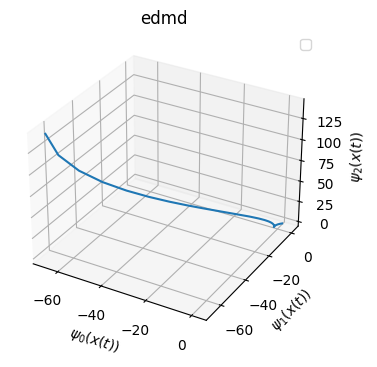

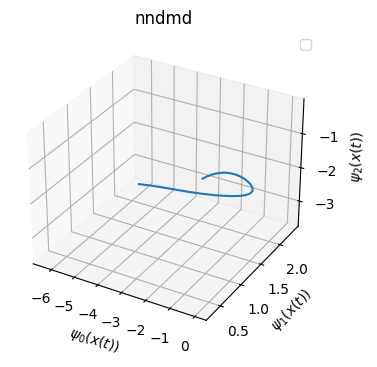

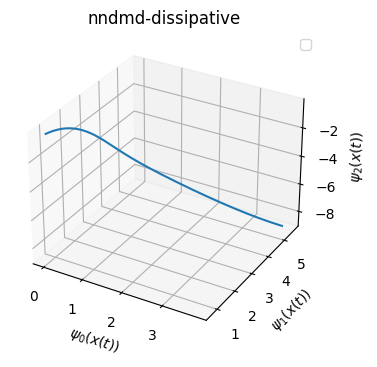

In [210]:
from mpl_toolkits.mplot3d import Axes3D

phi_edmd_test = model_edmd.psi(Xtest.T)
phi_nn_test = model.psi(Xtest.T)
phi_nn_d_test = model_d.psi(Xtest.T)
    
title_list = ['edmd','nndmd','nndmd-dissipative']
phi_list = [phi_edmd_test, phi_nn_test, phi_nn_d_test]

for i in range(3):
    phi = phi_list[i]
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(np.real(phi)[0,:],np.real(phi)[1,:],np.real(phi)[2,:])
    ax.set_xlabel(r'$\psi_0(x(t))$')
    ax.set_ylabel(r'$\psi_1(x(t))$')
    ax.set_zlabel(r'$\psi_2(x(t))$')
    
    plt.title(title_list[i])
    plt.legend(loc='best')

Access the matrices related to Koopman operator

In [211]:
model.A.shape

(3, 3)

In [212]:
model.C.shape

(2, 3)

In [213]:
model.W.shape

(2, 3)